# Polymer Systems

In [1]:
using Clapeyron
import PyPlot; const plt = PyPlot

PyPlot

## Gas solubility
Let us first consider an important property when considering polymer systems: solubility of light gases. In the first instance, let us construct the model. 

The real challenge when it comes to polymers isn't really the calculations. It is the model construction. Most polymer parameters are expressed in terms of the molecular weight of the polymer:

| Polymer | ϵ (K) | σ (Å) | m per Mw |
|---------|-----------------------------------------|----------------|-----------------|
| PS      | 348.20                                  | 4.152          | 0.0205          |
| PBD     | 288.84                                  | 4.097          | 0.0245          |
| PMMA    | 264.60                                  | 3.553          | 0.0270          |

As such, the model needs to be constructed manually.

We will consider the case of the solubility of carbon dioxide in polystyrene:

In [10]:
Mw = 1000.

polymer_param = ParamTable(:like,(
                species = ["PS"],
                Mw = [Mw],
                epsilon = [348.20],
                sigma = [4.152],
                segment = [0.0205*Mw],
                n_H = [0],
                n_e = [0]))

model = PCSAFT(["carbon dioxide","PS"]; userlocations=[polymer_param]);

When we discuss the solubility of a light gas in polymer, what we are really talking about is equilibrium between vapor and liquid phase. This is just a bubble point!

Unfortunately, this type of calculation can be quite challenging as the polymer will usually be present in the vapor phase in _very_ low concentrations. A nice trick is to simply treat the polymer as non-volatile. This can be done by specifying this in our method:

In [14]:
method = FugBubblePressure(nonvolatiles=["PS"]);

We can then solve for the bubble point:

In [17]:
T = 298.15
x = [0.001, 0.999]

(p, vl, vv, y) = bubble_pressure(model, T, x, method)

(953.3656403574464, 0.0009402248232084722, 2.600091016602562, [1.0, 0.0])

We can now trace the solubility of carbon dioxide in PS for a range of pressures. Typically, the solubility is expressed using mass fractions, whereas the `bubble_pressure` functiont takes mole fractions. We provide converters through `Clapeyron.mass_to_mole(model, x)`:

In [52]:
w = LinRange(0.,0.15, 100)
p = zeros(length(w))
for i in 2:length(w)
    x = Clapeyron.mass_to_mole(model,[w[i],1-w[i]]) 
    p[i] = bubble_pressure(model, T, x, method)[1]
end

Plotting:

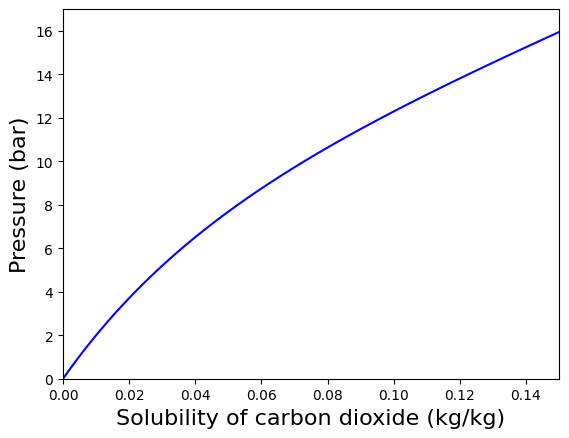

In [54]:
plt.clf()
fig, ax = plt.subplots()
ax.plot(w, p ./ 1e5, color="blue")
ax.set_xlabel("Solubility of carbon dioxide (kg/kg)", fontsize=16)
ax.set_ylabel("Pressure (bar)", fontsize=16)
ax.set_xlim(0, 0.15)
ax.set_ylim(0, 17);
# ax.set_xticks(fontsize=14)
# ax.set_yticks(fontsize=14);

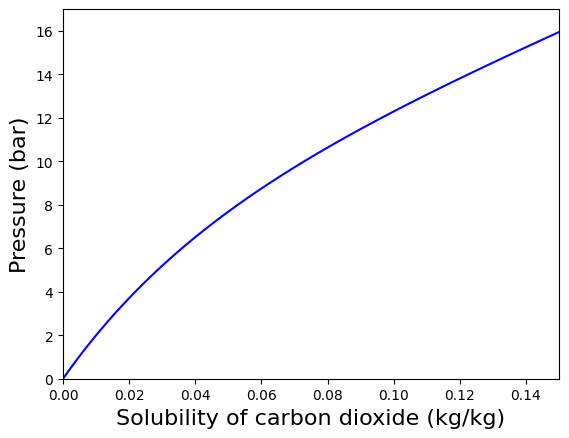

In [55]:
display(fig)

## Polymer Blend immiscibility
In the case of polymer blends, we are also interested in obtaining the miscibility gap / cloud points. The classic model to use here would be Flory–Huggins. Unlike conventional models, we have allowed the chain length to be an easily adjustable parameter:

In [113]:
N = [10,10]
model = FH(["poly1","poly2"], N; userlocations=(;
    Mw = [1.,1.],
    a  = [0. 0.0; 0.0 0.],
    b  = [0. 100.; 100. 0.]    
));

Where `a` and `b` are related to the parameter $\chi$ through:
$$
\chi = a + \frac{b}{T}
$$

We can plot the gibbs free energy of mixing to observe the miscibility gap:

In [107]:
T = 298.15
p = 1e5
w = LinRange(0,1,100)
g_mix = zeros(length(w))
for i in 2:length(w)-1
    x = Clapeyron.mass_to_mole(model, [w[i], 1-w[i]])
    g_mix[i] = mixing(model, p, T, x, gibbs_free_energy)
end

Visualizing:

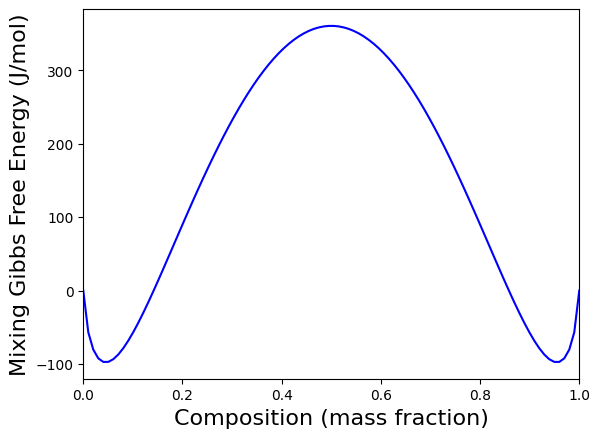

(0.0, 1.0)

In [108]:
plt.clf()
fig, ax = plt.subplots()
ax.plot(w, g_mix, color="blue")
ax.set_xlabel("Composition (mass fraction)", fontsize=16)
ax.set_ylabel("Mixing Gibbs Free Energy (J/mol)", fontsize=16)
ax.set_xlim(0,1)

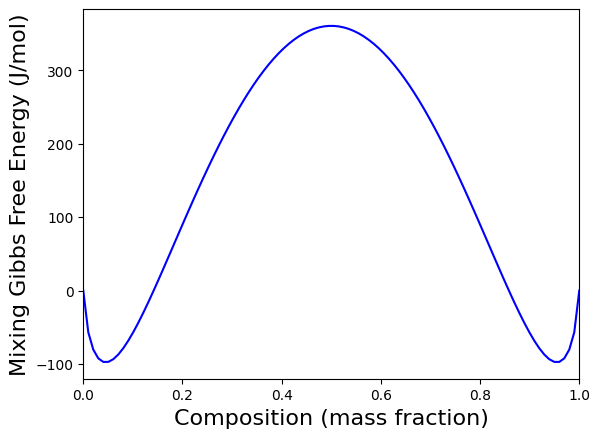

In [109]:
display(fig)

This is pretty much identical to the liquid–liquid phase diagram we generated previously! As such, we can use `tp_flash` for this:

In [110]:
N    = 200
Tlle = LinRange(300.,550.,N)
x1   = zeros(N)
x2   = zeros(N)

K0 = [1e5, 1e-4]
z  = [0.5,0.5]

idxend = N
for i in 1:N
    (n,_,_) = tp_flash(model, p, Tlle[i], z, RRTPFlash(equilibrium=:lle, K0=K0))
    K0 = n[2,:]./n[1,:]
    z = (n[1,:]+n[2,:])/2
    x1[i] = minimum(n[:,1])
    x2[i] = maximum(n[:,1])
    if abs(x1[i]-x2[i])<1e-3
        idxend = i
        break
    end
end

Plotting:

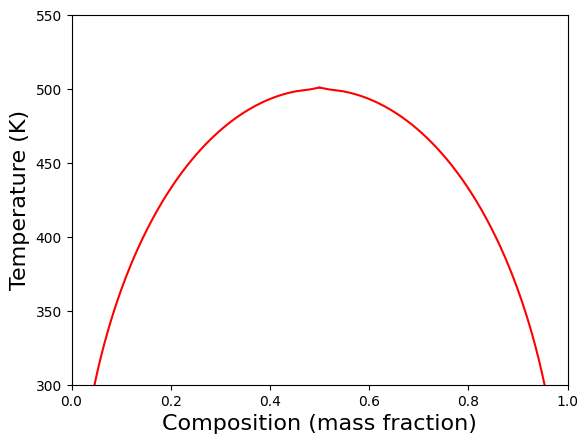

(300.0, 550.0)

In [111]:
plt.clf()
fig, ax = plt.subplots()
ax.plot(x1[1:idxend], Tlle[1:idxend], color="red")
ax.plot(x2[1:idxend], Tlle[1:idxend], color="red")
ax.set_xlabel("Composition (mass fraction)", fontsize=16)
ax.set_ylabel("Temperature (K)", fontsize=16)
ax.set_xlim(0,1)
ax.set_ylim(300, 550)

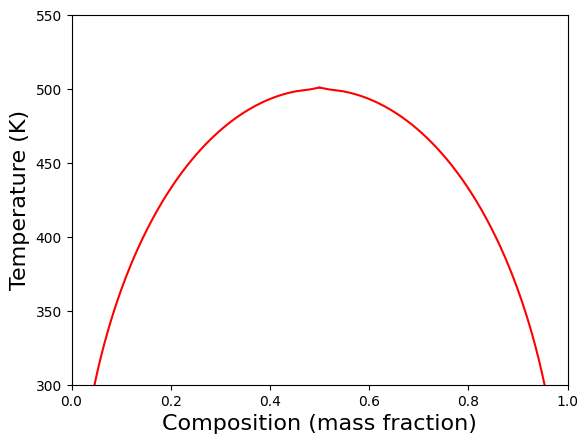

In [112]:
display(fig)

## Custom Models
Lets say you want to implement your own modified version of Flory–Huggins where, for some reason, you want to change the enthalpic term to:
$$
\sum_{ij}\chi_{ij}\phi_i^2\phi_j^2
$$
You can do so with Clapeyron!

The first step is to import all the tools we'll need. Since Flory–Huggins is classified as an activity coefficient model, we need to import:

In [14]:
import Clapeyron: ActivityModel, excess_gibbs_free_energy, getparams, @comps, R̄

Next, we need to define the model parameters:

In [9]:
struct MyFHParam <: EoSParam
    Mw::SingleParam{Float64}
    N::SingleParam{Float64}
    a::PairParam{Float64}
    b::PairParam{Float64}
end

We then need to define a model type that will be associated with our implementation:

In [10]:
abstract type MyFHModel <: ActivityModel end

struct MyFH <: MyFHModel
    components::Array{String,1}
    params::MyFHParam
end

Next, we need to define a model constructor (the `MyFH(components,N)` function). Normally, this would be handled automatically by Clapeyron, but since we want to add `N` as a special input, we need to do so manually:

In [ ]:
function MyFH(components, N; userlocations = String[], 
    verbose = false)

    params = getparams(components; userlocations = userlocations, ignore_missing_singleparams=["a","b","N"], verbose = verbose)

    a = params["a"]
    b = params["b"]
    Mw  = get(params,"Mw",SingleParam("Mw",components))
    N   = SingleParam("N", components, N)

    Mw.values .*= N.values

    packagedparams = MyFHParam(Mw,N,a,b)
    model = MyFH(components,packagedparams)
    return model
end

MyFH

Finally, all we need to do is define an expression for the excess Gibbs free energy:

In [15]:
function excess_gibbs_free_energy(model::MyFHModel, p, T, z)
    a = model.params.a.values
    b = model.params.b.values
    N = model.params.N.values
    n = sum(z)
    
    x = z ./ n
    NT = sum(x .* N)
    ϕ = x .* N ./ NT  # Volume fraction of each component
    res = 0.0
    for i ∈ @comps
        xi = x[i]
        ϕi = ϕ[i]
        ri = N[i]/NT
        res += xi * log(ri)
        for j ∈ i+1:length(model.components)
            ϕj = ϕ[j]
            χij = a[i,j] + b[i,j]/T
            res += ϕi^2 * ϕj^2 * χij * NT
        end
    end
    return R̄ * T * res * n
end

excess_gibbs_free_energy (generic function with 11 methods)

And with that, you can assemble your model:

In [46]:
N = [10,10]
model = MyFH(["poly1","poly2"], N; userlocations=(;
    Mw = [1.,1.],
    a  = [0. 0.0; 0.0 0.],
    b  = [0. 200.; 200. 0.]    
));

In [52]:
T = 298.15
p = 1e5
w = LinRange(0,1,100)
g_mix = zeros(length(w))
for i in 2:length(w)-1
    x = Clapeyron.mass_to_mole(model, [w[i], 1-w[i]])
    g_mix[i] = mixing(model, p, T, x, gibbs_free_energy)
end

Plot the Gibbs free energy of mixing;

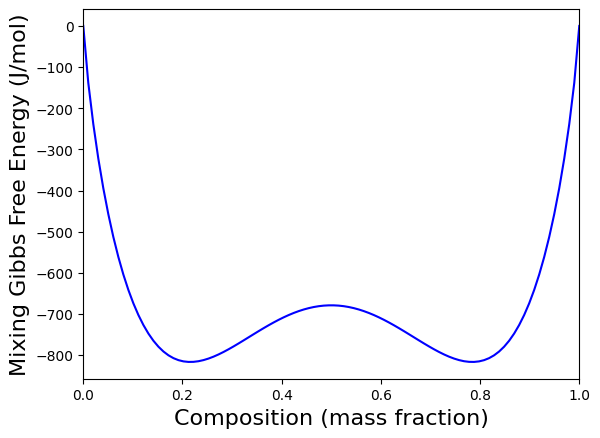

(0.0, 1.0)

In [53]:
plt.clf()
fig, ax = plt.subplots()
ax.plot(w, g_mix, color="blue")
ax.set_xlabel("Composition (mass fraction)", fontsize=16)
ax.set_ylabel("Mixing Gibbs Free Energy (J/mol)", fontsize=16)
ax.set_xlim(0,1)

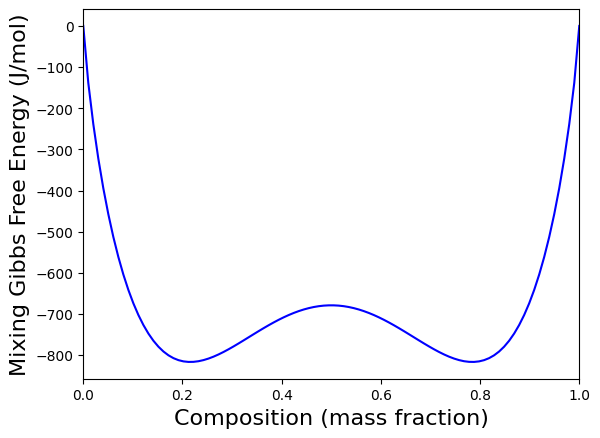

In [54]:
display(fig)

In [49]:
N    = 200
Tlle = LinRange(300.,550.,N)
x1   = zeros(N)
x2   = zeros(N)

K0 = [1e5, 1e-4]
z  = [0.5,0.5]

idxend = N
for i in 1:N
    (n,_,_) = tp_flash(model, p, Tlle[i], z, RRTPFlash(equilibrium=:lle, K0=K0))
    K0 = n[2,:]./n[1,:]
    z = (n[1,:]+n[2,:])/2
    x1[i] = minimum(n[:,1])
    x2[i] = maximum(n[:,1])
    if abs(x1[i]-x2[i])<1e-3
        idxend = i
        break
    end
end

And plot the miscibility gap:

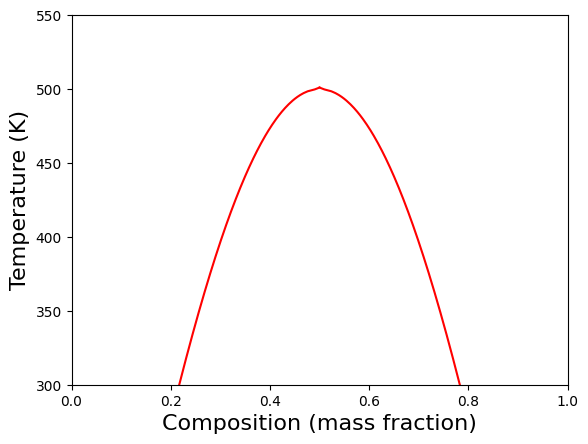

(300.0, 550.0)

In [55]:
plt.clf()
fig, ax = plt.subplots()
ax.plot(x1[1:idxend], Tlle[1:idxend], color="red")
ax.plot(x2[1:idxend], Tlle[1:idxend], color="red")
ax.set_xlabel("Composition (mass fraction)", fontsize=16)
ax.set_ylabel("Temperature (K)", fontsize=16)
ax.set_xlim(0,1)
ax.set_ylim(300, 550)

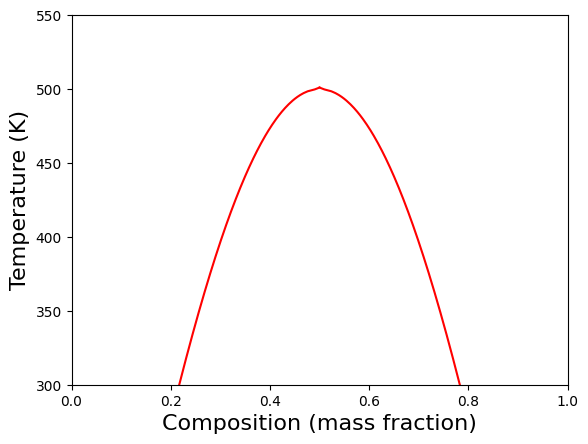

In [56]:
display(fig)